<center>

# Discrete Event Systems

## Home Assignment 3

### Model Checking with $\mu%$-Calculus

- - -

# Introduction

The objective of this home assignment is to deepen the understanding of temporal logic specifications and model checking algorithms based on $\mu$-calculus. You will achieve that through implementing a fixed-point algorithm for a particular _CTL*_ specification and test it out on a booking problem of variable size. 

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on Canvas**

## Comments and Recommendations
Once again:
* The following resources will be of great help to you for this assignment:
 * [Python docs](https://docs.python.org/3/)
 * [Google](https://www.google.com)
* This assignment is written for Python 3.5 or later!
* We will test your code with additional edge cases. So convince yourself that everything is correct before you submit.
* This assignment makes use of the Python package [numpy](https://docs.scipy.org/doc/numpy/). Make sure to have it installed.

In [1]:
try:
    import numpy as np
except ImportError:
    print("You need to install numpy! Open a command prompt and run 'pip install numpy'")

- - -

# Preliminaries

In this assignment, we will work with a more general model for discrete event systems called __Transition System__. A transition system $G$ is defined by a 6-tuple $G = \langle X, \Sigma, T, I, AP, \lambda \rangle$ where $X$ is a set of states, $\Sigma$ is a finite set of events, $T \subseteq X \times T \times X$ is a transition relation, where a transition $t = (x, a, x') \in T$, includes the source state $x$, the event label $a$, and the target state $x'$, $I \subseteq X$ is a set of possible initial states, $AP$ is a set of atomic propositions, and $\lambda: X \mapsto 2^{AP}$ is a state labeling function. A transition system  $G$ without the state labels, where $AP$ and $\lambda$ are excluded from $G$ is obviously an automaton without marked and forbidden states.

In order to implement a data structure corresponding to a transition system, we introduce a new class of _State_ objects.

In [2]:
class State(object):
    
    def __init__(self, name, labels=None):
        """
        Constructor  of the state.
        
        :param name: String. Default atomic proposition of the state
        :param labels: Set of atomic propositions that a true in the state
        """
        self.name = name
        assert labels is None or type(labels) is set
        self.labels = {name} if not labels else labels | {name}
    
    def __str__(self):
        """Prints the state in a pretty way."""
        return 'name: {} & ' \
               'labels: {}'.format(self.name, self.labels)
        
    def is_satisfied(self, atomic_proposition):
        """Checks whether the atomic proposition is statisfied in the state."""
        return atomic_proposition in self.labels

That allows us to define the _TransitionSystem_ class:

In [3]:
from util import Transition


class TransitionSystem(object):

    def __init__(self, states, init, events, trans):
        """
        This is the constructor of the transition system.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of States
        :param init: A set of initial States
        :param events: A set of events
        :param trans: A set of transitions
        """
        assert isinstance(states, set)
        self.states = states
        assert isinstance(init, set)
        self.init = init
        assert isinstance(events, set)
        self.events = events
        assert isinstance(trans, set)
        self.trans = trans

    def __str__(self):
        """Prints the transition system in a pretty way."""
        states_str = '{\n\t' + ',\n\t'.join(
            [str(s) for s in self.states]) + '\n\t}'
        init_str = '{\n\t' + ', '.join([str(s.name) for s in self.init]) + '\n\t}'
        trans_str = '\n\t'.join(
            ['{} --{}--> {},'.format(t.source.name, t.event, t.target.name) for t in self.trans])
        trans_str = '{\n\t' + trans_str + '\n\t}'
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n'.format(
                   states_str, init_str, self.events, trans_str)

    def __eq__(self, other):
        """Checks if two transition systems are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

Now, consider the Petri net $P_1$ of a booking problem that is shown below. 
![petri net](fig/petri_net.png)
Two parallel processes require two resources $R_1$ and $R_2$ for their operations. Although appearing simple, this system may exhibit undesirable behavior. For the majority of the assignment we will work with this system. 

In [4]:
from util import PetriNet
from util import Place, Arc
from util import plot_petrinet


def make_petrinet(p11_tokens, p21_tokens, R1_tokens, R2_tokens):
    return PetriNet(places=[Place('p11', p11_tokens), Place('p12', 0),
                            Place('p21', p21_tokens), Place('p22', 0),
                            Place('R1', R1_tokens), Place('R2', R2_tokens)],
                    transitions={'a1', 'b1', 'a2', 'b2'},
                    arcs={Arc('p11', 'a1', 1),
                          Arc('a1', 'p12', 1),
                          Arc('p12', 'b1', 1),
                          Arc('b1', 'p11', 1),
                          Arc('R1', 'a1', 1),
                          Arc('R1', 'b2', 1),
                          Arc('b1', 'R1', 1),
                          Arc('b2', 'R1', 1),
                          Arc('R2', 'a2', 1),
                          Arc('R2', 'b1', 1),
                          Arc('b1', 'R2', 1),
                          Arc('b2', 'R2', 1),
                          Arc('p21', 'a2', 1),
                          Arc('a2', 'p22', 1),
                          Arc('p22', 'b2', 1),
                          Arc('b2', 'p21', 1)})


P_1 = make_petrinet(p11_tokens=3, p21_tokens=2, R1_tokens=2, R2_tokens=1)

We have also implemented a function in the PetriNet class that generates the corresponding reachability graph.

P_1:


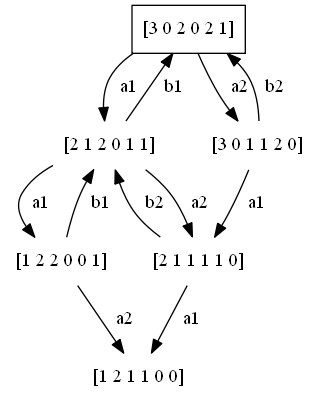

In [5]:
from util import plot_digraph

print('P_1:')
plot_digraph(P_1.make_reachability_graph(), 'fig/P_1_reach_graph')

To be able to use $\mu$-calculus to check the Petri net model, we need to transform it into a transition system, though. The below function does that.

T_1:


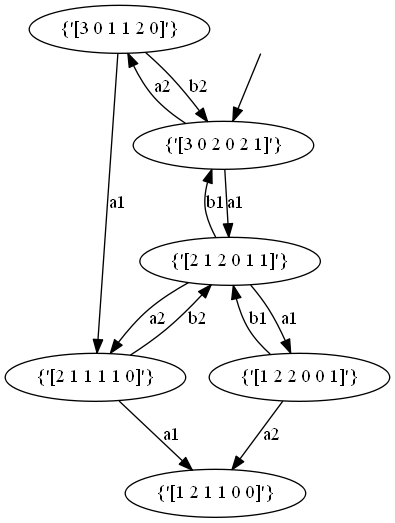

In [6]:
from util import plot_transitionsystem


def make_transition_system(petri_net):
    """Transforms a PetriNet to a TransitionSystem."""
    G = petri_net.make_reachability_graph()
    states = {State(n) for n in G.nodes}
    
    def get_state(node):
        for s in states:
            if s.name == node:
                return s
    
    init = {get_state(G.init)}
    events = petri_net.transitions
    trans = {Transition(get_state(e.source), e.label, get_state(e.target)) for e in G.edges}
    return TransitionSystem(states, init, events, trans)


T_1 = make_transition_system(P_1)
print('T_1:')
plot_transitionsystem(T_1, 'fig/P_1_transition_system')

---

# Task 1

## ___CTL*___-Specification to $\mu$-Calculus *[2p]*

In this assignment, you will implement the $\mu$-calculus algorithms for the booking problem $P_i$ shown above. Specifically, you will check its TransitionSystem model $T_i$ for the following temporal logic specification given in ___CTL*___:

<center>
    $\varphi_i = \forall \square \exists \lozenge m_i$,
</center>
with $m_i$ indicating a specific initial marking of $P_i$ (e.g. $m_1 = [3 0 2 0 2 1]$). 

* In simple words, what does this specification $\varphi_1 = \forall \square \exists \lozenge m_1$ say and why does it specify a desired behavior? Write your answer below. ***[1p]***

YOUR ANSWER HERE

Now, 
* transform the ___CTL*___ formula $\varphi_1$ to $\mu$-calculus set expressions. Show, also intermediate results. ***[1p]***
* *Note*: [This webpage](http://detexify.kirelabs.org/classify.html) may be useful for finding the right LaTex symbols .

YOUR ANSWER HERE

---

# Task 2

$\mu$-calculus includes next modality functions $f \in \mathcal{F}$, namely $f = \exists \bigcirc$ and $f = \forall \bigcirc$. You will implement them as __predecessor set operations__ in this section of the assignment. 

## Task 2.1 - $\text{Pre}^\exists$ Operator *[2p] *

This set operator is defined as

<center>
   $\text{Pre}^\exists(Y) = \{x \mid (\exists a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

Now,
* implement the $\text{Pre}^\exists$ set operator in the `pre_exists` function.
* _Hint:_ The inbuilt Python function [`any`](https://docs.python.org/3/library/functions.html#any) might be useful here.

In [7]:
# You might want to use one of these...
from util import filter_trans_by_source, filter_trans_by_events, filter_trans_by_target
from util import extract_elems_from_trans, flip_trans

In [16]:
def pre_exists(Y, ts):
    """
    Returns the new set of states for which the exists next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    return {trans.source for trans in filter_trans_by_target(ts.trans, Y)}

In [ ]:
# space for your own tests

In [17]:
s1 = State(1)
s2 = State(2)

T0 = TransitionSystem({s1}, {s1}, set(), set())
assert pre_exists(set(), T0) == set()
assert pre_exists({s1}, T0) == set()

T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
assert pre_exists(set(), T1) == set()
assert pre_exists({s1}, T1) == {s1}

T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert pre_exists(set(), T2) == set()
assert pre_exists({s1}, T2) == set()
assert pre_exists({s2}, T2) == {s1}
assert pre_exists({s1, s2}, T2) == {s1}

## Task 2.2 - $\text{Pre}^\forall$ Operator *[2p] *

This set operator is defined as

<center>
   $\text{Pre}^\forall(Y) = \{x \mid (\forall a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

Now,
* implement the $\text{Pre}^\forall$ set operator in the `pre_forall` function.
* _Hint:_ The inbuilt Python function [`all`](https://docs.python.org/3/library/functions.html#all) might be useful here.

In [145]:
def pre_forall(Y, ts):
    """
    Returns the new set of states for which the forall next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    
    x = set()
    for state in ts.states:
        #print("-----------")

        #print("Beginning loop")
        #print("current state: ",state)
        temp_trans = filter_trans_by_source(ts.trans,{state})
        #print("All targets we can reach for current state: ", extract_elems_from_trans(temp_trans,'target'))
        #print("Y:" ,Y)
        print(extract_elems_from_trans(temp_trans,'target').issubset(Y))
        if (all({extract_elems_from_trans(temp_trans,'target').issubset(Y)})):
            #print("adding forall state")
            x.add(state)
        elif temp_trans == set(): 
            #print("adding terminal state")
            
            x.add(state)
            
    #print("Output states", x)
    return x
    #return {state for state in pre_forany(Y, ts)
    #        if all([filter_trans_by_source(ts.trans, ).target in Y])}

IndentationError: unexpected indent (<ipython-input-145-76731e3df1dd>, line 23)

In [143]:
T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert pre_forall({s1, s2}, T2) == {s1, s2}

-----------
Beginning loop
current state:  name: 1 & labels: {1}
All targets we can reach for current state:  {<__main__.State object at 0x0000021C7D0815F8>}
Y: {<__main__.State object at 0x0000021C7D081630>, <__main__.State object at 0x0000021C7D0815F8>}
True
adding forall state
-----------
Beginning loop
current state:  name: 2 & labels: {2}
All targets we can reach for current state:  set()
Y: {<__main__.State object at 0x0000021C7D081630>, <__main__.State object at 0x0000021C7D0815F8>}
True
adding forall state
Output states {<__main__.State object at 0x0000021C7D081630>, <__main__.State object at 0x0000021C7D0815F8>}


In [144]:
s1 = State(1)
s2 = State(2)

T0 = TransitionSystem({s1}, {s1}, set(), set())
assert pre_forall(set(), T0) == {s1}
assert pre_forall({s1}, T0) == {s1}

T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
assert pre_forall(set(), T1) == set()
assert pre_forall({s1}, T1) == {s1}

T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert pre_forall(set(), T2) == {s2}
assert pre_forall({s1}, T2) == {s2}
assert pre_forall({s2}, T2) == {s1, s2}
assert pre_forall({s1, s2}, T2) == {s1, s2}

-----------
Beginning loop
current state:  name: 1 & labels: {1}
All targets we can reach for current state:  set()
Y: set()
True
adding forall state
Output states {<__main__.State object at 0x0000021C7D092080>}
-----------
Beginning loop
current state:  name: 1 & labels: {1}
All targets we can reach for current state:  set()
Y: {<__main__.State object at 0x0000021C7D092080>}
True
adding forall state
Output states {<__main__.State object at 0x0000021C7D092080>}
-----------
Beginning loop
current state:  name: 1 & labels: {1}
All targets we can reach for current state:  {<__main__.State object at 0x0000021C7D092080>}
Y: set()
False
Output states set()
-----------
Beginning loop
current state:  name: 1 & labels: {1}
All targets we can reach for current state:  {<__main__.State object at 0x0000021C7D092080>}
Y: {<__main__.State object at 0x0000021C7D092080>}
True
adding forall state
Output states {<__main__.State object at 0x0000021C7D092080>}
-----------
Beginning loop
current state:  na

---

# Task 3

## Model Checking through Fixed-Point Iteration *[2p]*

After having reformulated $\varphi_i = \forall \square \exists \lozenge m_i$ as $\mu$-calculus set expressions, and having implemented both $\text{Pre}^\exists$ and $\text{Pre}^\forall$, we can start on the actual model checking algorithm. 

* Implement the function `is_always_eventually_satisfied` that takes as inputs an atomic proposition (e.g. $m_i$) and a TransitionSystem. It then checks whether the TransitionSystem satisfies $\varphi_i$. ***[2p]***
* _Hint:_ You need to implement both a least fixed-point iteration $\mu Z$ and a greatest fixed-point iteration $\nu Y$.

In [ ]:
def is_always_eventually_satisfied(m_i, ts):
    """
    Checks if a TransitionSystem always eventually satisfies an atomic proposition.
    
    :param m_i: String/integer. Atomic proposition
    :param ts: TransitionSystem to check
    """
    satisfied = False
    # YOUR CODE HERE
    raise NotImplementedError()
    return satisfied


m_1 = '[3 0 2 0 2 1]'
print('T_1 {} satisfy phi_1!'.format('does' if is_always_eventually_satisfied(m_1, T_1) else 'does NOT'))

In [ ]:
# space for your own tests

In [ ]:
s1 = State(1)
s2 = State(2)

T0 = TransitionSystem({s1}, {s1}, set(), set())
assert is_always_eventually_satisfied(1, T0) == True

T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
assert is_always_eventually_satisfied(1, T1) == True

T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
assert is_always_eventually_satisfied(1, T2) == False
assert is_always_eventually_satisfied(2, T2) == True

T3 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), Transition(s1, 'a', s2)})
assert is_always_eventually_satisfied(1, T3) == False
assert is_always_eventually_satisfied(2, T3) == True

T4 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), 
                                              Transition(s1, 'a', s2), 
                                              Transition(s2, 'a', s2)})
assert is_always_eventually_satisfied(1, T4) == False
assert is_always_eventually_satisfied(2, T4) == True

s3 = State(3)
s4 = State(4)
T5 = TransitionSystem({s1, s2, s3, s4}, {s1}, {'a', 'b'}, 
                      {Transition(s1, 'a', s2),
                       Transition(s1, 'b', s3),
                       Transition(s2, 'a', s1),
                       Transition(s2, 'b', s4),
                       Transition(s3, 'a', s1),
                       Transition(s3, 'b', s4),
                       Transition(s4, 'a', s2)})
assert is_always_eventually_satisfied(1, T5) == True
assert is_always_eventually_satisfied(2, T5) == True
assert is_always_eventually_satisfied(3, T5) == True
assert is_always_eventually_satisfied(4, T5) == True

---

# Task 4

## Solving the Booking Problem *[2p]*

It seems that there is an issue with the booking of the resources in the system (the Petri net from earlier) at some point. And that even pertains when we scale the system.

In [ ]:
# e.g. multiplying all tokens by factor 7
m_2 = '[21 0 14 0 14 7]'
T_2 = make_transition_system(make_petrinet(21, 14, 14, 7))
print('T_2 {} satisfy phi_2!'.format('does' if is_always_eventually_satisfied(m_2, T_2) else 'does NOT'))
plot_transitionsystem(T_2, 'fig/T_2')

Given that observation:

* Change $P_1$ so that the booking problem is resolved. Elements of the original structure of the Petri net (places and arcs) must not be removed in that. ***[1p]***

In [ ]:
def make_fixed_petrinet():
    """Makes a new, altered, issue-free version of P_1"""
    # YOUR CODE HERE
    raise NotImplementedError()
    return P


P_3 = make_fixed_petrinet()
T_3 = make_transition_system(P_3)
print('T_3 {} satisfy phi_3!'.format('does' if is_always_eventually_satisfied(str(P_3.init_marking), T_3)
                                     else 'does NOT'))
print('P_3:')
plot_petrinet(P_3, 'fig/P_3')

* Describe briefly in words how you could implement your proposed changes in the real system. ***[1p]***

YOUR ANSWER HERE

## Bonus Task (optional)

* Can you derive a general rule to avoid the booking problem for the given Petri net structure of $P_1$? If yes, explain it with a few words. ***[+1p]***

YOUR ANSWER HERE

---

That is all there is. If you are done,

* Save the notebook
* Upload the .ipynb file to Canvas
* Give yourself a pat on the back! 